# CNN Tutorial

Sources used:
* https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
* https://cs231n.github.io/convolutional-networks/
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html



## Notes:

* CNN has three layers:
    * Convolution: uses filters to scan input and output feature map/activation map
    * Pooling: takes either the maximum value or average value of features (maximum pooling is more common)
    * Fully Connected: feature map are inputted to neurons
* Example structure:
    * Input [32x32x3]: [width x height x color channels]
    * CONV [32x32x12]: last value depends on num. of filters, in this example 12 filters
    * RELU [32x32x12]: activation function, same volume size
    * POOL [16x16x12]: downsampling along width/height
    * FC [1x1x10]: compute class cores, num. 1-10 corr. to class score, each neuron is connected to all num. in prev. volume
* Used in image classification

## Implementation:

In [62]:
import torch
import torchvision
import torchvision.transforms as transforms

In [63]:
# Set up:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


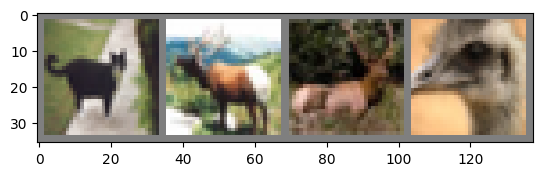

cat   deer  deer  bird 


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize training data

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [65]:
# Define CNN
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [66]:
# Define loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [67]:
# Training
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.167
[1,  4000] loss: 1.885
[1,  6000] loss: 1.710
[1,  8000] loss: 1.598
[1, 10000] loss: 1.550
[1, 12000] loss: 1.477
[2,  2000] loss: 1.411
[2,  4000] loss: 1.368
[2,  6000] loss: 1.339
[2,  8000] loss: 1.334
[2, 10000] loss: 1.285
[2, 12000] loss: 1.285
Finished Training


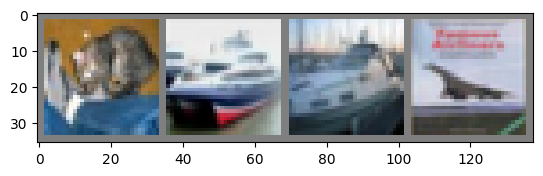

GroundTruth:  cat   ship  ship  plane


In [71]:
# Evaluating using testing data

# Testing data
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [72]:
# Input testing data
outputs = net(images)

In [77]:
# Predict labels by indexing highest energy

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  dog   car   horse


In [78]:
# Visualize accuracy

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [79]:
# Identify accuracy by class

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.6 %
Accuracy for class: car   is 74.0 %
Accuracy for class: bird  is 47.0 %
Accuracy for class: cat   is 15.3 %
Accuracy for class: deer  is 51.1 %
Accuracy for class: dog   is 47.0 %
Accuracy for class: frog  is 67.8 %
Accuracy for class: horse is 62.4 %
Accuracy for class: ship  is 65.5 %
Accuracy for class: truck is 65.5 %
